In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import math

# Read Data and Initial Inspection

Phase 1: original data

In [39]:
dataPath = '../../data/'
dataset = pd.read_csv(dataPath+'Clean_RawData.csv')
dataset.head()

Archive No  D (m)    l  m (kg)  v (m/s)  E (kPa)  cu (kPa)  E/cu  \
0           1   0.04  0.0     0.1        5      100         1   100   
1           3   0.04  0.0     0.2        5      100         1   100   
2          13   0.04  0.0     0.1       10      500         5   100   
3          16   0.04  0.0     0.2       10      500         5   100   
4          19   0.04  0.0     0.5        5      500         5   100   

        G/cu  Total penetration/ D  Time of travel (s)   \
0  33.333333                4.0678              0.06678   
1  33.333333                7.9759              0.13092   
2  33.333333                3.2486              0.02578   
3  33.333333                5.7715              0.04606   
4  33.333333                4.2121              0.06164   

   Initial Kinetic Energy = mv2/2 (kgm2/s2)  (cupD3/4) (kgm2/s2)  \
0                                      1.25             0.050265   
1                                      2.50             0.050265   
2                                      5.00             0.251327   
3                                     10.00             0.251327   
4                                      6.25             0.251327   

   (mv2/2)/ (cupD3/4)  
0           24.867960  
1           49.735920  
2           19.894368  
3           39.788736  
4           24.867960

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 14 columns):
Archive No                                  223 non-null int64
D (m)                                       223 non-null float64
l                                           223 non-null float64
m (kg)                                      223 non-null float64
v (m/s)                                     223 non-null int64
E (kPa)                                     223 non-null int64
cu (kPa)                                    223 non-null int64
E/cu                                        223 non-null int64
G/cu                                        223 non-null float64
Total penetration/ D                        223 non-null float64
Time of travel (s)                          223 non-null float64
Initial Kinetic Energy = mv2/2 (kgm2/s2)    223 non-null float64
(cupD3/4) (kgm2/s2)                         223 non-null float64
(mv2/2)/ (cupD3/4)                          223 non-null flo

Nothing looks weird so far; data columns are all numeric.

The names of the columns, however, are not gonna be convenient for coding, so I am simplifying them for now and we can later on revert them back to original names if desired.

In [41]:
def simplifyNames(df, names):
    df.rename(columns = names, inplace = True)

def reventBackNames(df, names):
    invNames = {v: k for k, v in names.items()}
    df.rename(columns = names, inplace = True)

In [42]:
columnNames = {'Archive No': 'id','D (m)': 'd', 'l': 'lambda', 'm (kg)': 'm', 'v (m/s)': 'v', 'E (kPa)': 'e', 'cu (kPa)': 'cu', 
               'E/cu': 'e/cu', 'G/cu': 'g/cu', 'Total penetration/ D': 'tp/d', 'Time of travel (s) ': 'tt',
               'Initial Kinetic Energy = mv2/2 (kgm2/s2)': 'ike', '(cupD3/4) (kgm2/s2)': 'cup', '(mv2/2)/ (cupD3/4)': 'cup/ke'}

simplifyNames(dataset, columnNames)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 14 columns):
id        223 non-null int64
d         223 non-null float64
lambda    223 non-null float64
m         223 non-null float64
v         223 non-null int64
e         223 non-null int64
cu        223 non-null int64
e/cu      223 non-null int64
g/cu      223 non-null float64
tp/d      223 non-null float64
tt        223 non-null float64
ike       223 non-null float64
cup       223 non-null float64
cup/ke    223 non-null float64
dtypes: float64(9), int64(5)
memory usage: 24.5 KB


### Missing Values

In [43]:
dataset.isnull().sum()

id        0
d         0
lambda    0
m         0
v         0
e         0
cu        0
e/cu      0
g/cu      0
tp/d      0
tt        0
ike       0
cup       0
cup/ke    0
dtype: int64

PERFECT; there is no missing values... Well we did expect it as these are data generated from simulation, so indeed there won't be any missing values... daahhh :)

# EDA

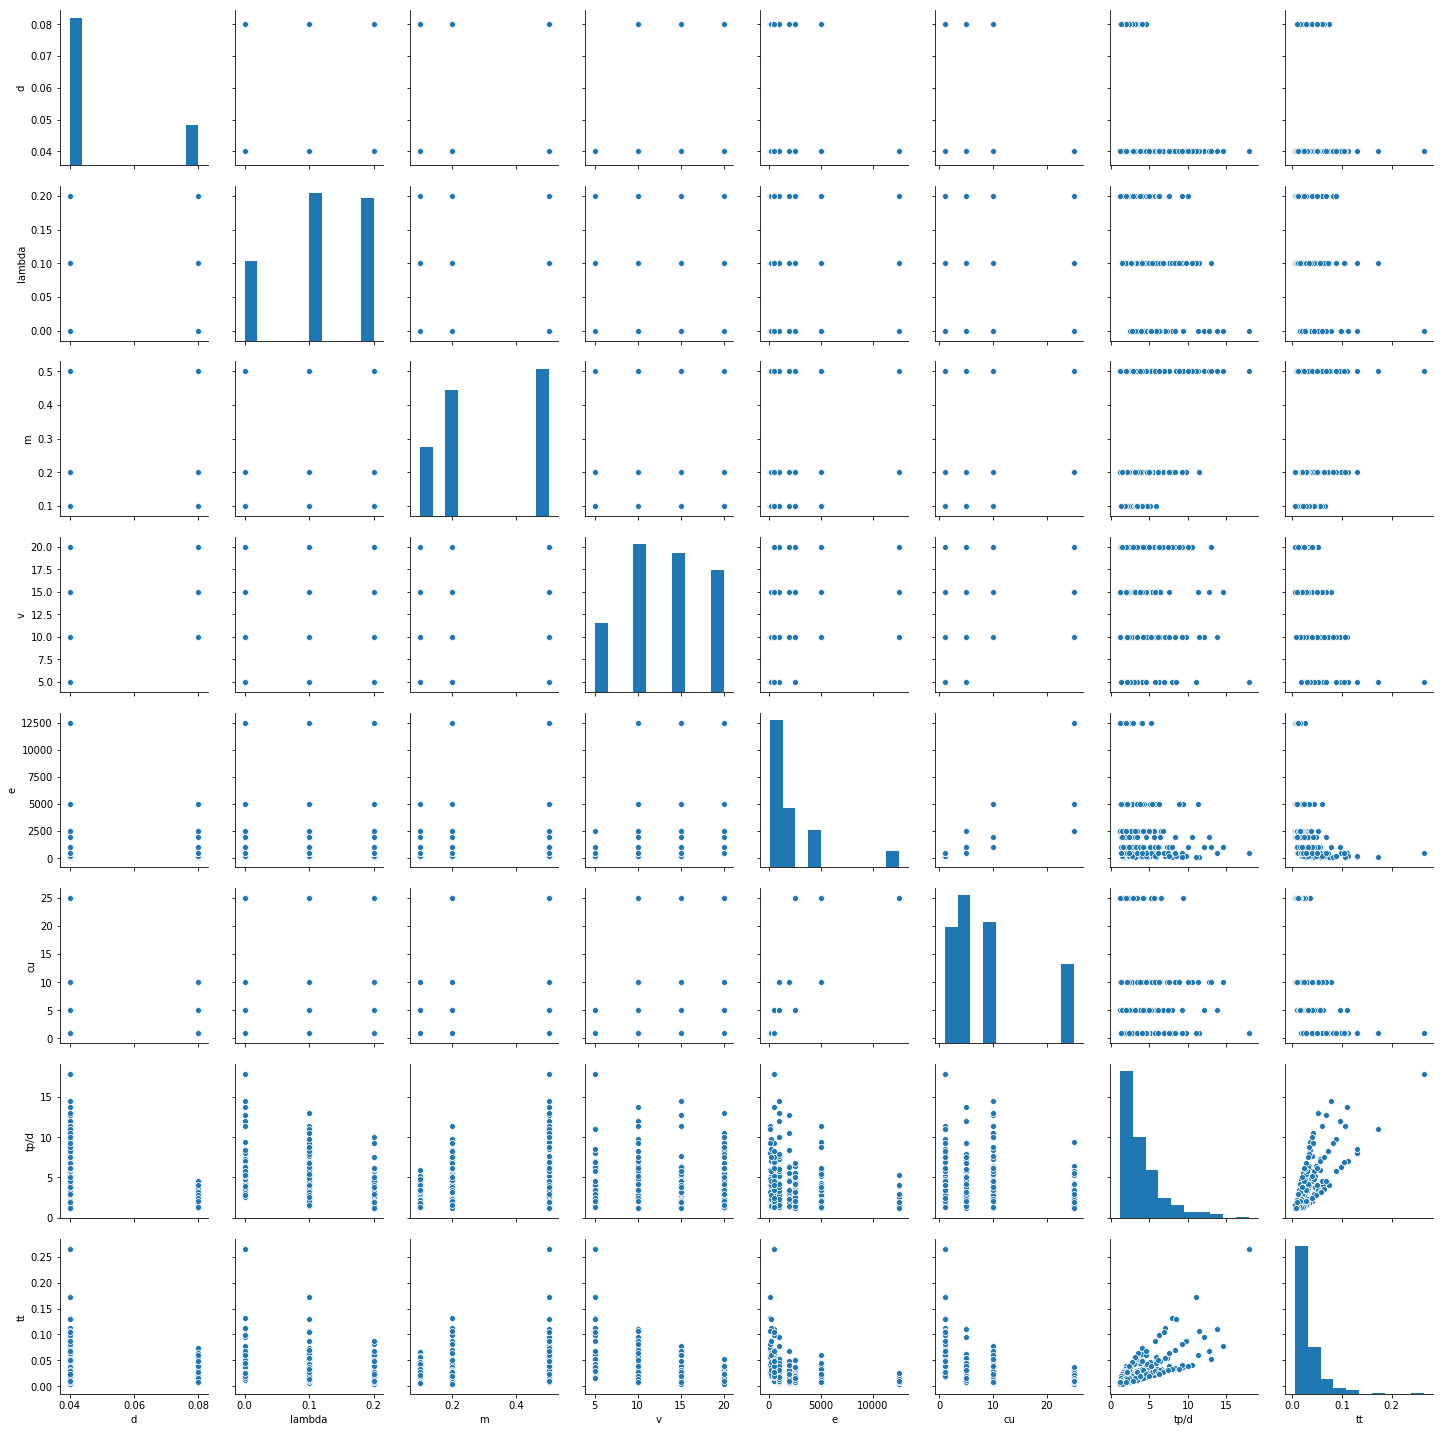

In [44]:
cols = ['d', 'lambda', 'm', 'v', 'e', 'cu', 'tp/d', 'tt']
sns.pairplot(dataset[cols], height = 2.5)
plt.show();

looks like there are some extreme e, cu, time and penetration parameters. But for now we will keep them in as I believe they will help with the interpolation rather than extrapolation! 

In this regards, I am also curious to see how many various instances we have per target variable variation?... 

In [45]:
targetCols = ['e', 'cu', 'lambda']
for col in targetCols:
    for val in dataset[col].unique():
        filteredData = dataset[dataset[col] == val]
        print("for value", val, "of variable", col, "there are", filteredData.shape[0], "instances in the dataset.")

for value 100 of variable e there are 14 instances in the dataset.
for value 500 of variable e there are 46 instances in the dataset.
for value 1000 of variable e there are 46 instances in the dataset.
for value 2500 of variable e there are 32 instances in the dataset.
for value 200 of variable e there are 20 instances in the dataset.
for value 2000 of variable e there are 19 instances in the dataset.
for value 5000 of variable e there are 32 instances in the dataset.
for value 12500 of variable e there are 14 instances in the dataset.
for value 1 of variable cu there are 56 instances in the dataset.
for value 5 of variable cu there are 71 instances in the dataset.
for value 10 of variable cu there are 58 instances in the dataset.
for value 25 of variable cu there are 38 instances in the dataset.
for value 0.0 of variable lambda there are 48 instances in the dataset.
for value 0.1 of variable lambda there are 89 instances in the dataset.
for value 0.2 of variable lambda there are 86 in

Interesting! Above analysis shows that for some values of traget variable, particularly in case of Young's Modulus, there are values with number of instances as low as 14! This should still be alright, but we need to be careful when we form our Train/Test splits of the dataset.

### Normality of traget variables

This is for the current analysis where we want to use Regression models for the task of prediction. We have to remember that this type of problem could also be modelled as a Classification problem, where instead of predicting continuous values of the target variable, we model the target as classes (e.g. example classes (bins) for cu: 0 to 5, 5 to 10, 10 to 20, 20 to 30 etc). I do recommend that we visit this as well, perhaps after Regression modelling. 

This is amining at improving the prediction power of out models further down the road. Normality of the arget variable is one of the Assumptions of Linear Regression.

Skew is: 2.287607148154171


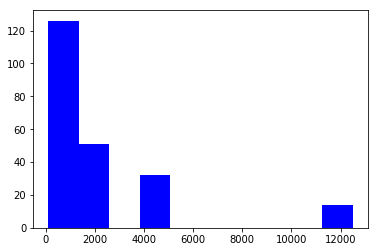

Skew is: -0.08360300583656906


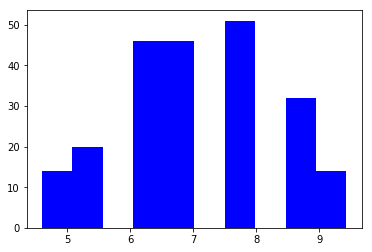

In [31]:
#Check skewness of the original data
print ("Skew is:", dataset['e'].skew())
plt.hist(dataset['e'], color='blue')
plt.show()

#Does log transformation make things better?
target = np.log(dataset.loc[dataset['e']>0,'e'])
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

#Yes, log is less skewed, so lets transform the original values
dataset['e'] = np.log(dataset['e'])

Skew is: 1.1671588492632903


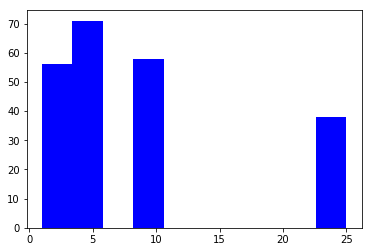

Skew is: -0.3261741485033525


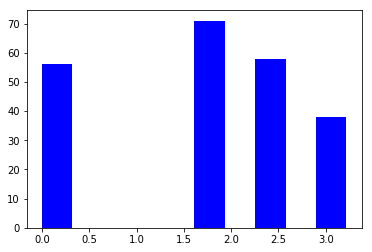

In [33]:
#Check skewness of the original data
print ("Skew is:", dataset['cu'].skew())
plt.hist(dataset['cu'], color='blue')
plt.show()

#Does log transformation make things better?
target = np.log(dataset.loc[dataset['cu']>0,'cu'])
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

#Yes, log is less skewed, so lets transform the original values
dataset['cu'] = np.log(dataset['cu'])

'e' and 'cu' do benefit from log transformation in terms of getting them closer to normality. However, 'lambda' has only 3 values, with one value being zero. Hence, it would not benefit from log transfromation.

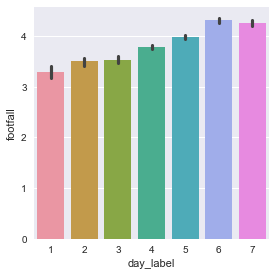

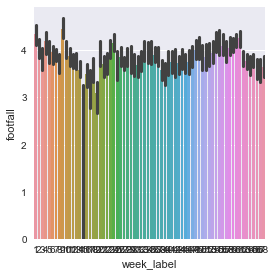

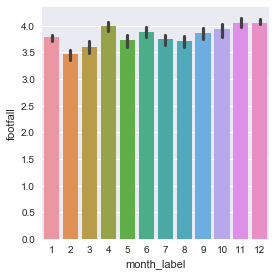

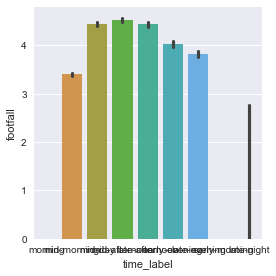

In [166]:
from numpy import median
g1 = sns.factorplot(x = 'day_label', y = 'footfall', data = train, estimator = median, kind = 'bar')
g1 = sns.factorplot(x = 'week_label', y = 'footfall', data = train, estimator = median, kind = 'bar')
g1 = sns.factorplot(x = 'month_label', y = 'footfall', data = train, estimator = median, kind = 'bar')
g1 = sns.factorplot(x = 'time_label', y = 'footfall', data = train, estimator = median, kind = 'bar')

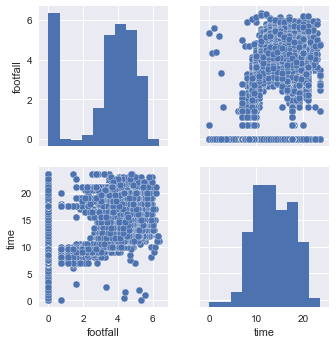

In [167]:
#scatterplot
#sns.set()
#cols = ['footfall', 'time']
#sns.pairplot(train[cols], size = 2.5)
#plt.show();

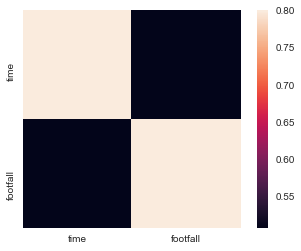

In [168]:
#correlation matrix
corrmat = train[['time', 'footfall']].corr()
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(corrmat, vmax=.8, square=True);

In [169]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total  Percent
time_label       0      0.0
month_label      0      0.0
week_label       0      0.0
day_label        0      0.0
footfall         0      0.0
time             0      0.0
date             0      0.0
store            0      0.0

In [170]:
#search for outliers
from sklearn.preprocessing import StandardScaler
#standardizing data
footfall_scaled = StandardScaler().fit_transform(train['footfall'][:,np.newaxis]);
low_range = footfall_scaled[footfall_scaled[:,0].argsort()][:10]
high_range= footfall_scaled[footfall_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.71808446]
 [-1.71808446]
 [-1.71808446]
 [-1.71808446]
 [-1.71808446]
 [-1.71808446]
 [-1.71808446]
 [-1.71808446]
 [-1.71808446]
 [-1.71808446]]

outer range (high) of the distribution:
[[1.5066729 ]
 [1.53380778]
 [1.5440589 ]
 [1.54631026]
 [1.55742585]
 [1.57686488]
 [1.5863235 ]
 [1.60775872]
 [1.61766918]
 [1.64819238]]


In [175]:
#drop non-relevant columns
train.drop(['date'], axis=1, inplace=True)                
train.drop(['time'], axis=1, inplace=True)
train.drop(['store'], axis=1, inplace=True)
#convert categorical variable into dummy
train['time_label'] = pd.get_dummies(train['time_label'])
train.head()

footfall  day_label  week_label  month_label  time_label
0  0.000000          7           1           10           0
1  0.000000          7           1           10           0
2  0.000000          7           1           10           0
3  4.553877          7           1           10           0
4  4.219508          7           1           10           0

In [176]:
y_train = train["footfall"]
X_train = train.drop(labels = ["footfall"],axis = 1)

In [10]:
#****************** Ensemble Models *******************************************
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.linear_model import LinearRegression
#from sklearn.neural_network import MLPRegressor
#from sklearn.svm import SVR
#from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, learning_curve
#import seaborn as sns
#from xgboost import XGBRegressor

# Cross validate model with Kfold stratified cross val
#kfold = KFold(n_splits=5)

# Modeling step Test differents algorithms 
#random_state = 2
#regressors = []
#regressors.append(SVR())
#regressors.append(MLPRegressor(random_state=random_state))
#regressors.append(LinearDiscriminantAnalysis())
#regressors.append(XGBRegressor())
#print(regressors)

In [177]:
X = X_train.values
y = y_train.values
#cv_results = []
#for regressor in regressors :
#    cv_results.append(cross_val_score(regressor, X, y = y, scoring = "neg_mean_squared_error", cv = 10, n_jobs = 1))

In [178]:
#cv_means = []
#cv_std = []
#for index, cv_result in enumerate(cv_results):
#    if index != 2 and index != 3:
#        cv_means.append(cv_result.mean())
#        cv_std.append(cv_result.std())
    
#cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
#                       "Algorithm":["SVR","MultipleLayerPerceptron","XGBoost"]})

#g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
#g.set_xlabel("Mean Accuracy")
#g = g.set_title("Cross validation scores")

In [179]:
#for index, res in enumerate(cv_results):
#    print(index, " - ", res)

In [180]:
#**********************GRID SEARCH ********************************************
from sklearn.model_selection import GridSearchCV
def evaluateModelPerformance(est, params, X, y):
    grid_search = GridSearchCV(estimator = est,
                               param_grid = params,
                               scoring = "neg_mean_squared_error",
                               cv = 5, n_jobs = 3)
    
    grid_search = grid_search.fit(X, y)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    return best_accuracy, best_parameters
#******************************************************************************    
#****************** XGBoost ***************************************************
tuningDict = {}
# Fitting XGBoost to the Training set
from xgboost import XGBRegressor
regressor = XGBRegressor()
#regressor.fit(X, y)

In [181]:
#Step All:
parameters = {'n_estimators': [i for i in range(400, 1000, 50)],
             'learning_rate': [0.1],
             'max_depth': [i for i in range(3,8)],
             'min_child_weight': [3, 4, 5, 6, 7, 8],
             'gamma': [i*0.1 for i in range(0, 85, 5)],
             'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'reg_alpha':[0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'reg_lambda':[0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-All'] = {'params': params, 'score': score}
print(tuningDict)

MemoryError: 

In [18]:
#Step 1:fix learning rate and determine optimum n_estimators:
parameters = {'n_estimators': [i for i in range(400, 1000, 50)],
             'learning_rate': [0.1]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-1'] = {'params': params, 'score': score}
print(tuningDict)

{'Step-1': {'params': {'learning_rate': 0.1, 'n_estimators': 600}, 'score': -551.76113602773}}


In [73]:
#Step 2:Tune max_depth and min_child_weight:
parameters = {'n_estimators': [600],
             'learning_rate': [0.1],
             'max_depth': [i for i in range(3,11)],
             'min_child_weight': [1, 2, 3, 5, 6, 7, 8, 9, 10]}
score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-2'] = {'params': params, 'score': score}
print(tuningDict)

{'Step-1': {'params': {'learning_rate': 0.1, 'n_estimators': 450}, 'score': -532.1234366332392}, 'Step-2': {'params': {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 450}, 'score': -522.4261503882893}}


In [19]:
#Step 3:Tune gamma:
parameters = {'n_estimators': [600],
             'learning_rate': [0.1],
             'max_depth': [4],
             'min_child_weight': [5],
             'gamma': [i*0.1 for i in range(0, 100, 2)]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-3'] = {'params': params, 'score': score}
print(tuningDict)

{'Step-1': {'params': {'learning_rate': 0.1, 'n_estimators': 600}, 'score': -551.76113602773}, 'Step-3': {'params': {'gamma': 4.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 600}, 'score': -546.3604133967552}}


In [20]:
#Step 4:Tune subsample and colsample_bytree:
parameters = {'n_estimators': [600],
             'learning_rate': [0.1],
             'max_depth': [4],
             'min_child_weight': [5],
             'gamma': [4.0],
             'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-4'] = {'params': params, 'score': score}
print(tuningDict)

{'Step-1': {'params': {'learning_rate': 0.1, 'n_estimators': 600}, 'score': -551.76113602773}, 'Step-3': {'params': {'gamma': 4.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 600}, 'score': -546.3604133967552}, 'Step-4': {'params': {'colsample_bytree': 0.9, 'gamma': 4.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 1.0}, 'score': -565.2038113830206}}


In [ ]:
#Step 5:Tuning Regularization Parameters:
parameters = {'n_estimators': [150],
             'learning_rate': [0.1],
             'max_depth': [3],
             'min_child_weight': [1],
             'gamma': [0.0],
             'subsample': [1.0],
             'colsample_bytree': [1.0],
             'reg_alpha':[0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'reg_lambda':[0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-5'] = {'params': params, 'score': score}
print(tuningDict)

In [ ]:
#Step 6: Tuning (decreasing) learning rate and n_estimators again:
parameters = {'n_estimators': [50*i for i in range(1, 20, 1)],
             'learning_rate': [0.01*i for i in range(1, 11, 1)],
             'max_depth': [3],
             'min_child_weight': [1],
             'gamma': [0.0],
             'subsample': [1.0],
             'colsample_bytree': [1.0],
             'reg_alpha':[0.4],
             'reg_lambda':[0.9]}

score, params = evaluateModelPerformance(regressor, parameters, X, y)
tuningDict['Step-6'] = {'params': params, 'score': score}
print(tuningDict)

In [ ]:
# Fitting tuned XGBoost and get the results
classifier = XGBClassifier(n_estimators= 150,
             learning_rate= 0.1,
             max_depth= 3,
             min_child_weight= 1,
             gamma= 0.0,
             subsample= 1.0,
             colsample_bytree= 1.0,
             reg_alpha= 0.3,
             reg_lambda= 0.4)

classifier.fit(X_used, y)
y_results = classifier.predict(X_target)